Evaluation of models trained on 5 core of Amazon Clothes dataset with hyperparameters:
loss: warp
learning_schedule: ‘adagrad’
no_components: 100
lr: 0.1
Pushing out the clusters of categories were activated.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from tqdm.auto import tqdm

from utils import analyse_metrics, analyse_embeddings, reduce_item_embeddings

In [5]:
tqdm.pandas()
THREADS = 8

In [6]:
epochs = [5, 25, 50, 250]
models = [pd.read_pickle(f'/pio/scratch/1/i313924/data/lightfm_data/model_{epochs}_epochs_all_clusters_adagrad_lr_0.1.pkl') for epochs in epochs]
train_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_interactions.npz')
test_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_test_interactions.npz')
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/5_core_dataset.pkl')

In [7]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)
abx_path = '/pio/scratch/1/recommender_systems/interim/ABX_tests/5_core.json'

In [14]:
item_ids = list(dataset.mapping()[2].keys())
women_ids = categories[(categories.category_1 == "Women") & (categories.asin.isin(item_ids))].asin.values
men_ids = categories[(categories.category_1 == "Men") & (categories.asin.isin(item_ids))].asin.values

PCA prepared
EPOCH: 5
EPOCH: 25
EPOCH: 50
EPOCH: 250


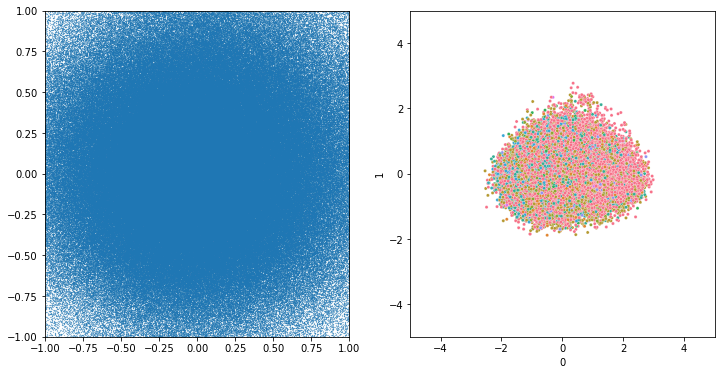

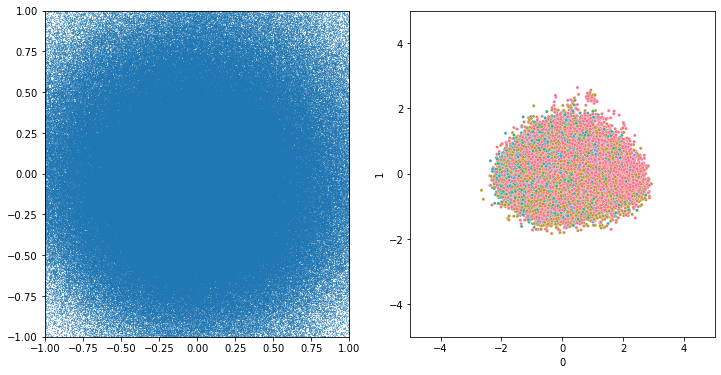

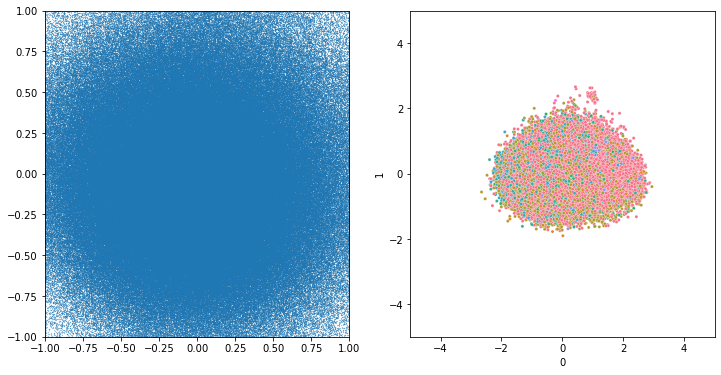

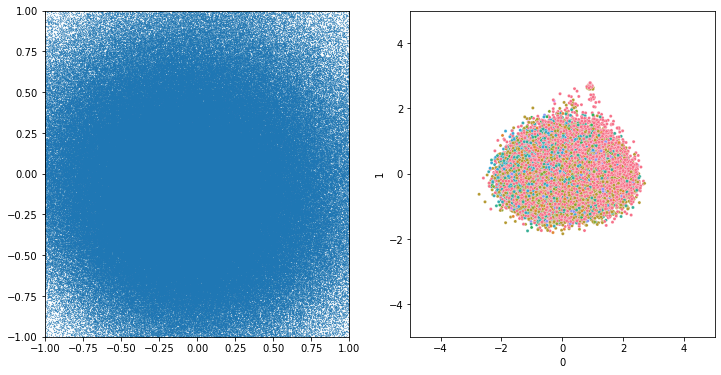

In [15]:
e, c, women_means, men_means, item_pca = analyse_embeddings(epochs, models, dataset, categories, abx_path, women_ids, men_ids)

Eucl dist


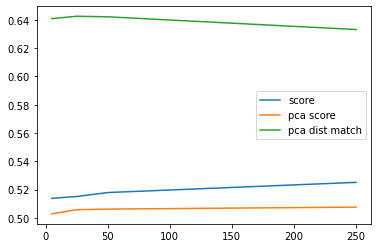

Cos dist


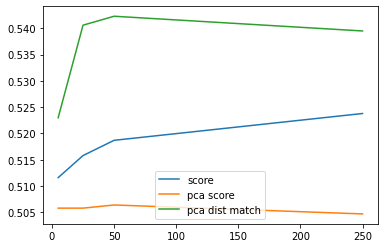

In [16]:
print("Eucl dist")
plt.plot(np.tile(epochs, (3, 1)).T, e)
plt.legend(["score", "pca score", "pca dist match"])
plt.show()
print("Cos dist")
plt.plot(np.tile(epochs, (3, 1)).T, c)
plt.legend(["score", "pca score", "pca dist match"])
plt.show()

In [17]:
e

[[0.5138, 0.5028, 0.6408],
 [0.5151, 0.5058, 0.6425],
 [0.5179, 0.5062, 0.6421],
 [0.5251, 0.5076, 0.6331]]

In [18]:
c

[[0.5116, 0.5058, 0.523],
 [0.5158, 0.5058, 0.5406],
 [0.5187, 0.5064, 0.5423],
 [0.5238, 0.5047, 0.5395]]

In [19]:
tqdm.pandas()
test_hit_rate_scores, test_recall_scores, test_precision_scores = analyse_metrics(models, train_interactions, test_interactions, dataset)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
test_recall_scores

[0.17034000000000002, 0.193, 0.20492000000000002, 0.23018000000000002]

In [21]:
test_precision_scores

[0.017034000000000004, 0.0193, 0.020492000000000003, 0.023018]

In [22]:
test_hit_rate_scores

[0.2815, 0.3174, 0.3431, 0.4093]

In [23]:
model = models[-1]
reduced_item_embeddings  = reduce_item_embeddings(model, dataset, categories)

<AxesSubplot:xlabel='0', ylabel='1'>

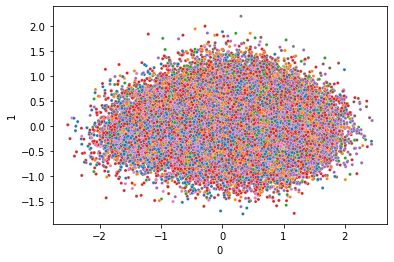

In [25]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[~reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10, legend=False)

<AxesSubplot:xlabel='0', ylabel='1'>

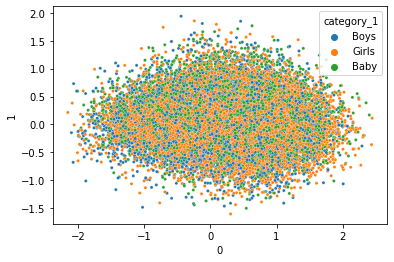

In [26]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Boys', 'Girls', 'Baby'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

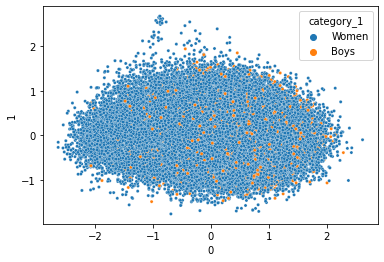

In [27]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Boys', 'Women'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

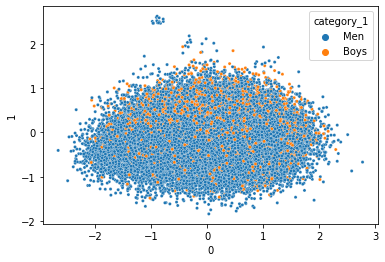

In [28]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Boys', 'Men'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

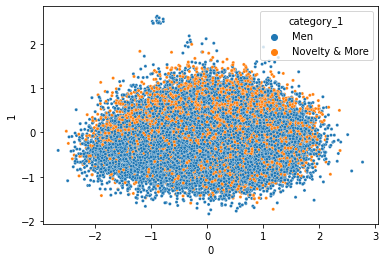

In [29]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Novelty & More', 'Men'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

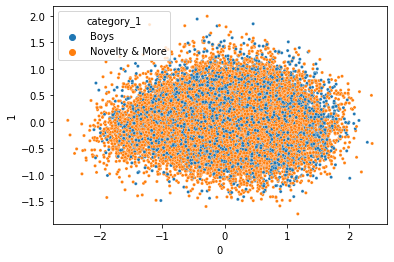

In [30]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Novelty & More', 'Boys'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

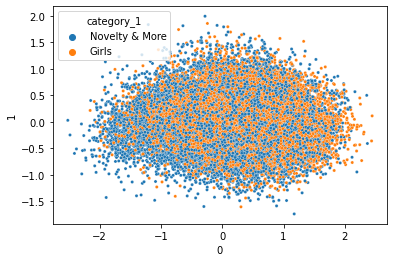

In [31]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Novelty & More', 'Girls'])], hue='category_1', s=10, legend=True)